In [8]:
!pip install japanize-matplotlib


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.special import j0  # 第1種0次ベッセル関数
from scipy.optimize import curve_fit
import pandas as pd
from datetime import datetime
import warnings
import japanize_matplotlib  # 日本語フォントの設定
warnings.filterwarnings('ignore')

print("ライブラリのインポートが完了しました！")

ライブラリのインポートが完了しました！


## 1. 微動観測の基礎

### 1.1 微動とは？
微動は地盤に常時存在する微小な振動です。主な発生源は：
- 海の波（0.1-1 Hz）
- 交通振動（1-20 Hz）
- 風、人間活動など

### 1.2 なぜ微動を使うのか？
- 人工的な振源が不要
- 低周波数成分が豊富（深部構造の探査に有利）
- 都市部でも観測可能

まず、模擬的な微動データを生成してみましょう。

### 表面波の分散性

微動の主成分である表面波（レイリー波）の位相速度$c(f)$は周波数$f$に依存します：

$$c(f) = f \times \lambda$$

探査深度は波長$\lambda$に比例し、おおよそ次の関係があります：

$$\text{探査深度} \approx \frac{\lambda}{2} \sim \frac{\lambda}{3}$$

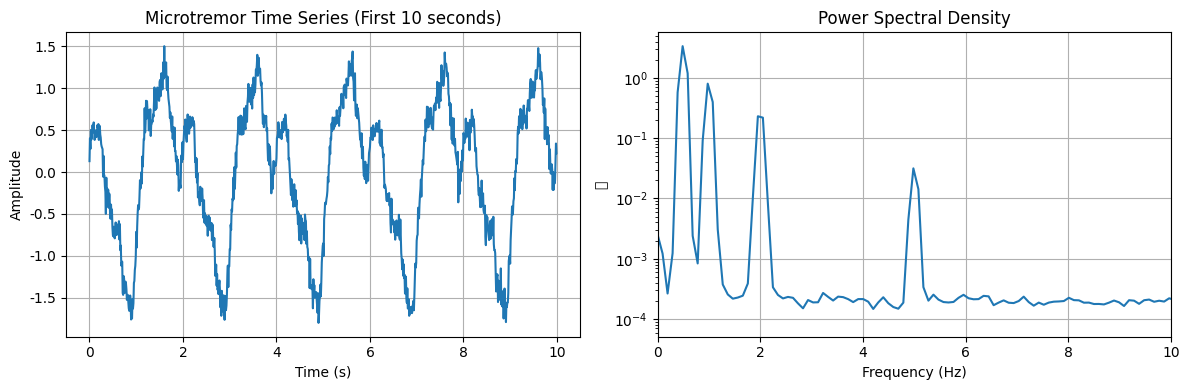

In [11]:
# 模擬微動データの生成
def generate_synthetic_microtremor(duration=300, fs=100, frequencies=[0.5, 1.0, 2.0, 5.0], 
                                  amplitudes=[1.0, 0.5, 0.3, 0.1]):
    """
    合成微動データを生成する関数
    
    Parameters:
    - duration: 記録時間 (秒)
    - fs: サンプリング周波数 (Hz)
    - frequencies: 含まれる周波数成分 (Hz)
    - amplitudes: 各周波数成分の振幅
    """
    t = np.arange(0, duration, 1/fs)
    data = np.zeros(len(t))
    
    # 複数の正弦波を重ね合わせて微動を模擬
    for f, a in zip(frequencies, amplitudes):
        phase = np.random.rand() * 2 * np.pi
        data += a * np.sin(2 * np.pi * f * t + phase)
    
    # ノイズを追加
    data += 0.1 * np.random.randn(len(t))
    
    return t, data

# データ生成と可視化
t, microtremor = generate_synthetic_microtremor()

# 時系列データの表示
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(t[:1000], microtremor[:1000])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Microtremor Time Series (First 10 seconds)')
plt.grid(True)

# スペクトルの計算と表示
plt.subplot(1, 2, 2)
f, psd = signal.welch(microtremor, fs=100, nperseg=1024)
plt.semilogy(f, psd)
plt.xlabel('Frequency (Hz)')
plt.ylabel('え')
plt.title('Power Spectral Density')
plt.grid(True)
plt.xlim(0, 10)

plt.tight_layout()
plt.show()

## 2. アレイ観測の概念

微動アレイ観測では、複数の地震計を配置して同時観測を行います。
一般的な配置：
- 円形アレイ（中心＋円周上）
- 三角形アレイ
- L字型アレイ

ここでは、円形アレイを例に解析を進めます。

In [ ]:
# 円形アレイの配置を可視化
def plot_array_configuration(radius=50, n_stations=4):
    """円形アレイの配置を描画"""
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # 中心点
    ax.scatter(0, 0, s=200, c='red', marker='s', label='Center')
    ax.text(0, 5, 'C', ha='center', fontsize=12)
    
    # 円周上の観測点
    angles = np.linspace(0, 2*np.pi, n_stations, endpoint=False)
    for i, angle in enumerate(angles):
        x = radius * np.cos(angle)
        y = radius * np.sin(angle)
        ax.scatter(x, y, s=200, c='blue', marker='^')
        ax.text(x, y+5, f'S{i+1}', ha='center', fontsize=12)
    
    # 円を描画
    circle = plt.Circle((0, 0), radius, fill=False, linestyle='--', color='gray')
    ax.add_patch(circle)
    
    ax.set_xlim(-radius*1.3, radius*1.3)
    ax.set_ylim(-radius*1.3, radius*1.3)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_title(f'Circular Array Configuration (r={radius}m)')
    ax.legend()
    
    return fig

# アレイ配置の表示
plot_array_configuration(radius=50, n_stations=4)
plt.show()

# 複数サイズのアレイ
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
radii = [10, 50, 200]
for ax, r in zip(axes, radii):
    plt.sca(ax)
    plot_array_configuration(radius=r, n_stations=4)
    ax.set_title(f'Array Size: {r}m\\nTarget Frequency: {100/r:.1f}-{500/r:.1f} Hz')
plt.tight_layout()
plt.show()

class SPACAnalysis:
    """SPAC法による解析クラス"""
    
    def __init__(self, data, fs, array_radius):
        """
        Parameters:
        - data: 観測データ (n_stations × n_samples)
        - fs: サンプリング周波数
        - array_radius: アレイ半径
        """
        self.data = data
        self.fs = fs
        self.radius = array_radius
        self.n_stations = data.shape[0]
        
    def compute_spac_coefficient(self, window_length=20, overlap=0.5):
        """空間自己相関係数を計算"""
        
        # 窓の設定
        nperseg = int(window_length * self.fs)
        noverlap = int(nperseg * overlap)
        
        # 中心点と周辺点のデータ
        center_data = self.data[0, :]  # 中心点
        
        # 各周波数での空間自己相関係数を格納
        spac_coeffs = []
        
        # 各周辺観測点との相関を計算
        for i in range(1, self.n_stations):
            # クロススペクトル密度の計算
            f, Pxy = signal.csd(center_data, self.data[i, :], 
                               fs=self.fs, nperseg=nperseg, noverlap=noverlap)
            
            # オートスペクトル密度の計算
            _, Pxx = signal.welch(center_data, fs=self.fs, 
                                 nperseg=nperseg, noverlap=noverlap)
            _, Pyy = signal.welch(self.data[i, :], fs=self.fs, 
                                 nperseg=nperseg, noverlap=noverlap)
            
            # 空間自己相関係数
            # ρ(r,f) = 2*Re[S12(f)] / sqrt(S11(f)*S22(f))
            spac = np.real(Pxy) / np.sqrt(Pxx * Pyy)
            spac_coeffs.append(spac)
        
        # 平均化
        self.frequencies = f
        self.spac_mean = np.mean(spac_coeffs, axis=0)
        self.spac_std = np.std(spac_coeffs, axis=0)
        
        return self.frequencies, self.spac_mean, self.spac_std
    
    def estimate_phase_velocity(self, freq_range=(0.5, 10)):
        """ベッセル関数フィッティングによる位相速度推定"""
        
        # 解析する周波数範囲を限定
        freq_mask = (self.frequencies >= freq_range[0]) & (self.frequencies <= freq_range[1])
        freq_analysis = self.frequencies[freq_mask]
        spac_analysis = self.spac_mean[freq_mask]
        
        phase_velocities = []
        
        for f, spac_val in zip(freq_analysis, spac_analysis):
            if f == 0 or abs(spac_val) > 1:
                phase_velocities.append(np.nan)
                continue
                
            # ベッセル関数の零点を探索
            # J0(2πfr/c) = spac_val を満たすcを探す
            def bessel_func(c):
                return j0(2 * np.pi * f * self.radius / c) - spac_val
            
            # 初期値の設定（探索範囲）
            c_min = 50  # 最小位相速度 (m/s)
            c_max = 1000  # 最大位相速度 (m/s)
            
            try:
                from scipy.optimize import brentq
                c = brentq(bessel_func, c_min, c_max)
                phase_velocities.append(c)
            except:
                phase_velocities.append(np.nan)
        
        self.phase_velocities = np.array(phase_velocities)
        self.freq_analysis = freq_analysis
        
        return freq_analysis, self.phase_velocities

In [ ]:
class SPACAnalysis:
    """SPAC法による解析クラス"""
    
    def __init__(self, data, fs, array_radius):
        """
        Parameters:
        - data: 観測データ (n_stations × n_samples)
        - fs: サンプリング周波数
        - array_radius: アレイ半径
        """
        self.data = data
        self.fs = fs
        self.radius = array_radius
        self.n_stations = data.shape[0]
        
    def compute_spac_coefficient(self, window_length=20, overlap=0.5):
        """空間自己相関係数を計算"""
        
        # 窓の設定
        nperseg = int(window_length * self.fs)
        noverlap = int(nperseg * overlap)
        
        # 中心点と周辺点のデータ
        center_data = self.data[0, :]  # 中心点
        
        # 各周波数での空間自己相関係数を格納
        spac_coeffs = []
        
        # 各周辺観測点との相関を計算
        for i in range(1, self.n_stations):
            # クロススペクトル密度の計算
            f, Pxy = signal.csd(center_data, self.data[i, :], 
                               fs=self.fs, nperseg=nperseg, noverlap=noverlap)
            
            # オートスペクトル密度の計算
            _, Pxx = signal.welch(center_data, fs=self.fs, 
                                 nperseg=nperseg, noverlap=noverlap)
            _, Pyy = signal.welch(self.data[i, :], fs=self.fs, 
                                 nperseg=nperseg, noverlap=noverlap)
            
            # 空間自己相関係数
            spac = np.real(Pxy) / np.sqrt(Pxx * Pyy)
            spac_coeffs.append(spac)
        
        # 平均化
        self.frequencies = f
        self.spac_mean = np.mean(spac_coeffs, axis=0)
        self.spac_std = np.std(spac_coeffs, axis=0)
        
        return self.frequencies, self.spac_mean, self.spac_std
    
    def estimate_phase_velocity(self, freq_range=(0.5, 10)):
        """ベッセル関数フィッティングによる位相速度推定"""
        
        # 解析する周波数範囲を限定
        freq_mask = (self.frequencies >= freq_range[0]) & (self.frequencies <= freq_range[1])
        freq_analysis = self.frequencies[freq_mask]
        spac_analysis = self.spac_mean[freq_mask]
        
        phase_velocities = []
        
        for f, spac_val in zip(freq_analysis, spac_analysis):
            if f == 0 or abs(spac_val) > 1:
                phase_velocities.append(np.nan)
                continue
                
            # ベッセル関数の零点を探索
            # J0(2πfr/c) = spac_val を満たすcを探す
            def bessel_func(c):
                return j0(2 * np.pi * f * self.radius / c) - spac_val
            
            # 初期値の設定（探索範囲）
            c_min = 50  # 最小位相速度 (m/s)
            c_max = 1000  # 最大位相速度 (m/s)
            
            try:
                from scipy.optimize import brentq
                c = brentq(bessel_func, c_min, c_max)
                phase_velocities.append(c)
            except:
                phase_velocities.append(np.nan)
        
        self.phase_velocities = np.array(phase_velocities)
        self.freq_analysis = freq_analysis
        
        return freq_analysis, self.phase_velocities

## 4. 実践：合成データでのSPAC解析

実際の地下構造を想定した合成データを生成し、SPAC法を適用してみましょう。

In [ ]:
# 合成アレイデータの生成
def generate_array_data(n_stations=5, array_radius=50, duration=300, fs=100):
    """
    表面波を含む合成アレイデータを生成
    """
    t = np.arange(0, duration, 1/fs)
    data = np.zeros((n_stations, len(t)))
    
    # 表面波の特性（周波数と位相速度）
    frequencies = [1.0, 2.0, 3.0, 5.0]
    phase_velocities = [300, 250, 200, 150]  # 深さとともに速度増加を模擬
    amplitudes = [1.0, 0.7, 0.5, 0.3]
    
    # 各観測点の位置（円形アレイ）
    angles = np.linspace(0, 2*np.pi, n_stations-1, endpoint=False)
    x_stations = [0] + [array_radius * np.cos(a) for a in angles]
    y_stations = [0] + [array_radius * np.sin(a) for a in angles]
    
    # 各周波数成分について
    for f, c, amp in zip(frequencies, phase_velocities, amplitudes):
        # 波の進行方向（ランダム）
        theta = np.random.rand() * 2 * np.pi
        kx = 2 * np.pi * f / c * np.cos(theta)
        ky = 2 * np.pi * f / c * np.sin(theta)
        
        # 各観測点での波形
        for i, (x, y) in enumerate(zip(x_stations, y_stations)):
            phase = kx * x + ky * y
            data[i, :] += amp * np.sin(2 * np.pi * f * t - phase)
    
    # ノイズを追加
    data += 0.1 * np.random.randn(*data.shape)
    
    return data, t

# データ生成
array_data, time = generate_array_data(n_stations=5, array_radius=50)

# 生成したデータの可視化
plt.figure(figsize=(12, 8))
for i in range(5):
    plt.subplot(5, 1, i+1)
    plt.plot(time[:500], array_data[i, :500])
    plt.ylabel(f'Station {i}')
    if i == 0:
        plt.title('Synthetic Array Data (First 5 seconds)')
    if i == 4:
        plt.xlabel('Time (s)')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# SPAC解析の実行
spac = SPACAnalysis(array_data, fs=100, array_radius=50)

# 空間自己相関係数の計算
freq, spac_coeff, spac_std = spac.compute_spac_coefficient(window_length=20)

# 結果の可視化
plt.figure(figsize=(12, 5))

# 空間自己相関係数
plt.subplot(1, 2, 1)
plt.plot(freq, spac_coeff, 'b-', linewidth=2, label='SPAC coefficient')
plt.fill_between(freq, spac_coeff - spac_std, spac_coeff + spac_std, 
                 alpha=0.3, color='blue', label='±1 std')
plt.xlabel('Frequency (Hz)')
plt.ylabel('SPAC Coefficient')
plt.title('Spatial Autocorrelation Coefficient')
plt.grid(True, alpha=0.3)
plt.xlim(0, 10)
plt.ylim(-0.5, 1.0)
plt.legend()

# ベッセル関数との比較
plt.subplot(1, 2, 2)
# いくつかの位相速度でベッセル関数を描画
velocities = [150, 200, 250, 300]
for v in velocities:
    bessel_values = [j0(2 * np.pi * f * 50 / v) for f in freq]
    plt.plot(freq, bessel_values, '--', alpha=0.5, label=f'v={v} m/s')

plt.plot(freq, spac_coeff, 'b-', linewidth=2, label='Observed')
plt.xlabel('Frequency (Hz)')
plt.ylabel('SPAC Coefficient')
plt.title('Comparison with Bessel Functions')
plt.grid(True, alpha=0.3)
plt.xlim(0, 10)
plt.ylim(-0.5, 1.0)
plt.legend()

plt.tight_layout()
plt.show()

### 理論分散曲線の計算

簡易的な2層モデルでは、位相速度は以下のような特性を示します：

- 高周波数（短波長）：第1層のS波速度$V_{s1}$に近づく
- 低周波数（長波長）：第2層のS波速度$V_{s2}$に近づく

波長$\lambda$と層厚$h_1$の関係により、次のような遷移が起こります：

$$c(f) = V_{s1} + (V_{s2} - V_{s1}) \cdot \left(1 - \exp\left(-\frac{2h_1}{\lambda}\right)\right)$$

In [ ]:
# 位相速度の推定
freq_analysis, phase_vel = spac.estimate_phase_velocity(freq_range=(0.5, 6))

# 分散曲線の表示
plt.figure(figsize=(10, 6))
plt.scatter(freq_analysis, phase_vel, s=50, c='blue', alpha=0.7, label='Estimated')

# 真の値をプロット（検証用）
true_freqs = [1.0, 2.0, 3.0, 5.0]
true_vels = [300, 250, 200, 150]
plt.plot(true_freqs, true_vels, 'r--', linewidth=2, marker='o', 
         markersize=8, label='True values')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase Velocity (m/s)')
plt.title('Dispersion Curve from SPAC Analysis')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(0, 7)
plt.ylim(0, 400)

# 対数軸での表示も追加
plt.figure(figsize=(10, 6))
plt.loglog(1/freq_analysis, phase_vel, 'bo-', markersize=6, label='Estimated')
plt.loglog(1/np.array(true_freqs), true_vels, 'r--', linewidth=2, 
           marker='s', markersize=8, label='True values')
plt.xlabel('Period (s)')
plt.ylabel('Phase Velocity (m/s)')
plt.title('Dispersion Curve (Log-Log Scale)')
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.xlim(0.1, 10)
plt.ylim(100, 500)

plt.show()

## 5. 地下構造の推定

分散曲線から地下構造（S波速度構造）を推定します。
簡単な2層モデルを例に、理論分散曲線の計算方法を示します。

In [ ]:
def simple_dispersion_curve(frequencies, h1, vs1, vs2):
    """
    簡単な2層モデルの理論分散曲線を計算
    
    Parameters:
    - frequencies: 周波数配列
    - h1: 第1層の層厚 (m)
    - vs1: 第1層のS波速度 (m/s)
    - vs2: 第2層（半無限）のS波速度 (m/s)
    
    Returns:
    - phase_velocities: 位相速度配列
    """
    phase_velocities = []
    
    for f in frequencies:
        # 波長
        lambda_min = vs1 / f
        lambda_max = vs2 / f
        
        # 簡易的な推定式（実際はより複雑）
        # 浅い深度では vs1 に近く、深い深度では vs2 に近づく
        depth_factor = 1 - np.exp(-2 * h1 / lambda_min)
        c = vs1 + (vs2 - vs1) * depth_factor
        
        phase_velocities.append(c)
    
    return np.array(phase_velocities)

# パラメータスタディ
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 周波数配列
f_theory = np.linspace(0.1, 10, 100)

# 1. 層厚の影響
ax = axes[0, 0]
for h in [5, 10, 20, 40]:
    c_theory = simple_dispersion_curve(f_theory, h, 150, 300)
    ax.plot(f_theory, c_theory, label=f'h1={h}m')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Phase Velocity (m/s)')
ax.set_title('Effect of Layer Thickness')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. 第1層速度の影響
ax = axes[0, 1]
for vs1 in [100, 150, 200, 250]:
    c_theory = simple_dispersion_curve(f_theory, 20, vs1, 400)
    ax.plot(f_theory, c_theory, label=f'Vs1={vs1}m/s')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Phase Velocity (m/s)')
ax.set_title('Effect of Layer 1 Velocity')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. 第2層速度の影響
ax = axes[1, 0]
for vs2 in [300, 400, 500, 600]:
    c_theory = simple_dispersion_curve(f_theory, 20, 150, vs2)
    ax.plot(f_theory, c_theory, label=f'Vs2={vs2}m/s')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Phase Velocity (m/s)')
ax.set_title('Effect of Layer 2 Velocity')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. 観測データとのフィッティング例
ax = axes[1, 1]
# 観測データ（先ほどの結果を使用）
valid_mask = ~np.isnan(phase_vel)
ax.scatter(freq_analysis[valid_mask], phase_vel[valid_mask], 
          s=50, c='blue', alpha=0.7, label='Observed')

# いくつかのモデルを試す
models = [
    (10, 180, 280, 'Model 1'),
    (15, 160, 300, 'Model 2'),
    (20, 150, 320, 'Model 3')
]

for h, vs1, vs2, label in models:
    c_theory = simple_dispersion_curve(freq_analysis, h, vs1, vs2)
    ax.plot(freq_analysis, c_theory, '--', linewidth=2, label=label)

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Phase Velocity (m/s)')
ax.set_title('Model Fitting Example')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 6)
ax.set_ylim(100, 400)

plt.tight_layout()
plt.show()

## 6. 実践演習

以下の演習問題に取り組んでみましょう：

### 演習1：ノイズの影響
異なるノイズレベルでのSPAC解析の安定性を調べてください。

### 演習2：アレイサイズの検討
異なるアレイサイズ（半径）での解析可能周波数範囲を調べてください。

### 演習3：観測点数の影響
観測点数を変えた場合の解析精度を評価してください。

In [ ]:
# 演習1の解答例：ノイズの影響
def analyze_noise_effect(noise_levels=[0.01, 0.05, 0.1, 0.2, 0.5]):
    """異なるノイズレベルでのSPAC解析"""
    
    fig, axes = plt.subplots(2, len(noise_levels), figsize=(15, 8))
    
    for idx, noise_level in enumerate(noise_levels):
        # データ生成（ノイズレベルを変更）
        t = np.arange(0, 300, 0.01)
        data = np.zeros((5, len(t)))
        
        # 表面波成分
        frequencies = [1.0, 2.0, 3.0, 5.0]
        phase_velocities = [300, 250, 200, 150]
        
        for i in range(5):
            for f, c in zip(frequencies, phase_velocities):
                phase = 2 * np.pi * f * i * 50 / (4 * c)  # 簡易的な位相差
                data[i, :] += np.sin(2 * np.pi * f * t - phase)
        
        # ノイズ追加
        data += noise_level * np.random.randn(*data.shape)
        
        # SPAC解析
        spac = SPACAnalysis(data, fs=100, array_radius=50)
        freq, spac_coeff, _ = spac.compute_spac_coefficient()
        
        # プロット
        ax1 = axes[0, idx]
        ax1.plot(t[:100], data[0, :100])
        ax1.set_title(f'Noise Level: {noise_level}')
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Amplitude')
        
        ax2 = axes[1, idx]
        ax2.plot(freq, spac_coeff)
        ax2.set_xlabel('Frequency (Hz)')
        ax2.set_ylabel('SPAC Coefficient')
        ax2.set_xlim(0, 10)
        ax2.set_ylim(-0.5, 1)
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 演習1の実行
print("演習1: ノイズレベルの影響")
analyze_noise_effect()

## 7. まとめと実践のポイント

### 重要なポイント
1. **アレイサイズの選択**：対象とする周波数帯域に応じて適切に選ぶ
2. **観測時間**：統計的に安定した結果を得るため、20-30分以上の観測を推奨
3. **データ品質管理**：過渡的なノイズの除去、機器の同期が重要
4. **解の非唯一性**：異なる地下構造モデルが同じ分散曲線を示す可能性がある

### 次のステップ
1. 実データの解析に挑戦
2. FK法など他の解析手法の習得
3. 逆解析手法（遺伝的アルゴリズムなど）の実装
4. 3次元構造への拡張

### 参考資料
- Okada, H. (2003): The Microtremor Survey Method
- 物理探査学会 (2008): 物理探査ハンドブック
- Geopsy プロジェクト: http://www.geopsy.org/

# 微動アレイ観測解析チュートリアル

このノートブックでは、微動アレイ観測データの解析手法を実践的に学びます。

## 学習目標
1. 微動観測の基本概念を理解する
2. SPAC法による位相速度の推定方法を習得する
3. 分散曲線から地下構造を推定する流れを理解する

## 必要なライブラリ
まず、必要なライブラリをインポートしましょう。